# Facial Landmark Detection - Demonstration
Introduction to Deep Learning - Murphy, Aziha, Alaa  

_This demo is specifically meant to be run in Google Colab! You can open it [here](https://colab.research.google.com/github/StrangeGirlMurph/Facial-Landmark-Detection/blob/master/demo.ipynb)._

# Preparation

To work with the preprocessed data and pretrained models we simply clone the GitHub repo and work from there.  
The GitHub repo includes all the major versions of the model and the whole dataset raw and preprocessed.

In [1]:
# Cloning the repository.
!git clone "https://github.com/StrangeGirlMurph/Facial-Landmark-Detection.git"
# Changing the working directory in Colab.
%cd "/content/Facial-Landmark-Detection/src"
# Pulling all the big files from the repository (mainly the trained models and the dataset) which can take a few seconds.
!git lfs pull

Cloning into 'Facial-Landmark-Detection'...
remote: Enumerating objects: 1777, done.
remote: Counting objects: 100% (494/494), done.
remote: Compressing objects: 100% (392/392), done.
remote: Total 1777 (delta 116), reused 469 (delta 100), pack-reused 1283
Receiving objects: 100% (1777/1777), 192.46 MiB | 16.39 MiB/s, done.
Resolving deltas: 100% (369/369), done.
/content/Facial-Landmark-Detection/src
Git LFS: (24 of 24 files) 821.04 MB / 821.04 MB


# Loading the data

Now we can load the data and specify what exactly it is what we want to load.

In [2]:
from util.dataUtil import loadData, loadAugmentedData
import numpy as np

# Loads the whole dataset including all of the unclean data but without the augmented data.
X_train, y_train = loadData(includeAugmented=False, percentageOfUncleanData=1, includeTestData=False)
# We load the augmented data seperately to being able to access it later on individually.
X_augmented, y_augmented = loadAugmentedData()

# Adding them together making the whole dataset the model was trained on.
X = np.concatenate((X_train, X_augmented))
y = np.concatenate((y_train, y_augmented))


> Loading the data...


The dataset with the augmented data in total consists of 17749 96x96 images and their corresponding labels (15 landmarks with x,y-coordinates each):

In [3]:
X.shape, y.shape

((17749, 96, 96, 1), (17749, 30))

Keep in mind though that this data is already preprocessed and the labels include filling values (-1) for the missing data.  
The data now consists of about 60% of augmented data and 20% filling values.

# Visualizing the data

Now that we have loaded the data. Let's look at some images and their landmarks beginning with two images of the original dataset.

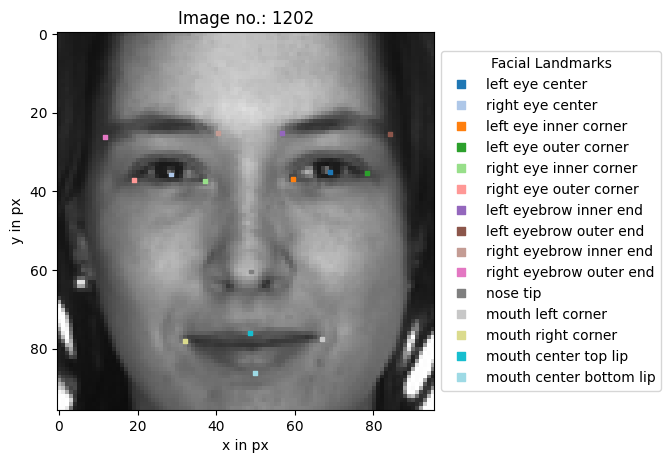

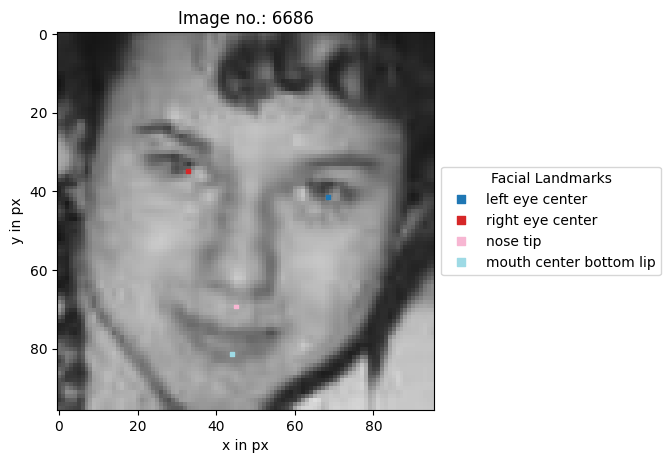

In [4]:
from util.plottingUtil import plotImageWithLabels

for i in [1202, 6686]:
  plotImageWithLabels(X[i], y[i], f"Image no.: {i}")

An example augmented image:

In [ ]:
plotImageWithLabels(X_augmented[625], y_augmented[625], f"Image no.: {625}")

# Loading the trained model

The fourth version of the model is the most recent and best performing one. The repository also includes all the older versions to compare them to the new one.

In [5]:
from util.modelUtil import loadModel

model = loadModel("../models/modelV4")


> Loading the model...


For the model we used a custom masked mean squared error loss plus the masked mean absolute error and masked accuracy as additional metrics.  
The model is a CNN and has in total 7,264,318 trainable parameters. It was trained using the ADAM optimizer in 40 minutes over 100 epochs.

In [6]:
print("Loss:", model.loss.__name__)
print("Metrics:", model.metrics_names)
model.summary(line_length=100)

Loss: masked_mean_squared_error
Metrics: ['loss', 'masked_mean_absolute_error', 'masked_accuracy']
Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d (Conv2D)                             (None, 96, 96, 32)                      288            
                                                                                                    
 leaky_re_lu (LeakyReLU)                     (None, 96, 96, 32)                      0              
                                                                                                    
 batch_normalization (BatchNormalization)    (None, 96, 96, 32)                      128            
                                                                                                    
 conv2d_1 (Conv2D)                           (None, 96, 96, 32)          

# Testing the model

Now that we have loaded the model and have a rough understanding of it we can test it.  
Our main goal is to apply the model to webcam input. But before testing on video it is best to first test the performance on the dataset itself.

## On the dataset itself

By testing on the dataset we can easily compare different versions of the model.  
The green points are marking the true labels and the blue ones the models prediction.

>>> Model V4 <<<

> Testing the model...


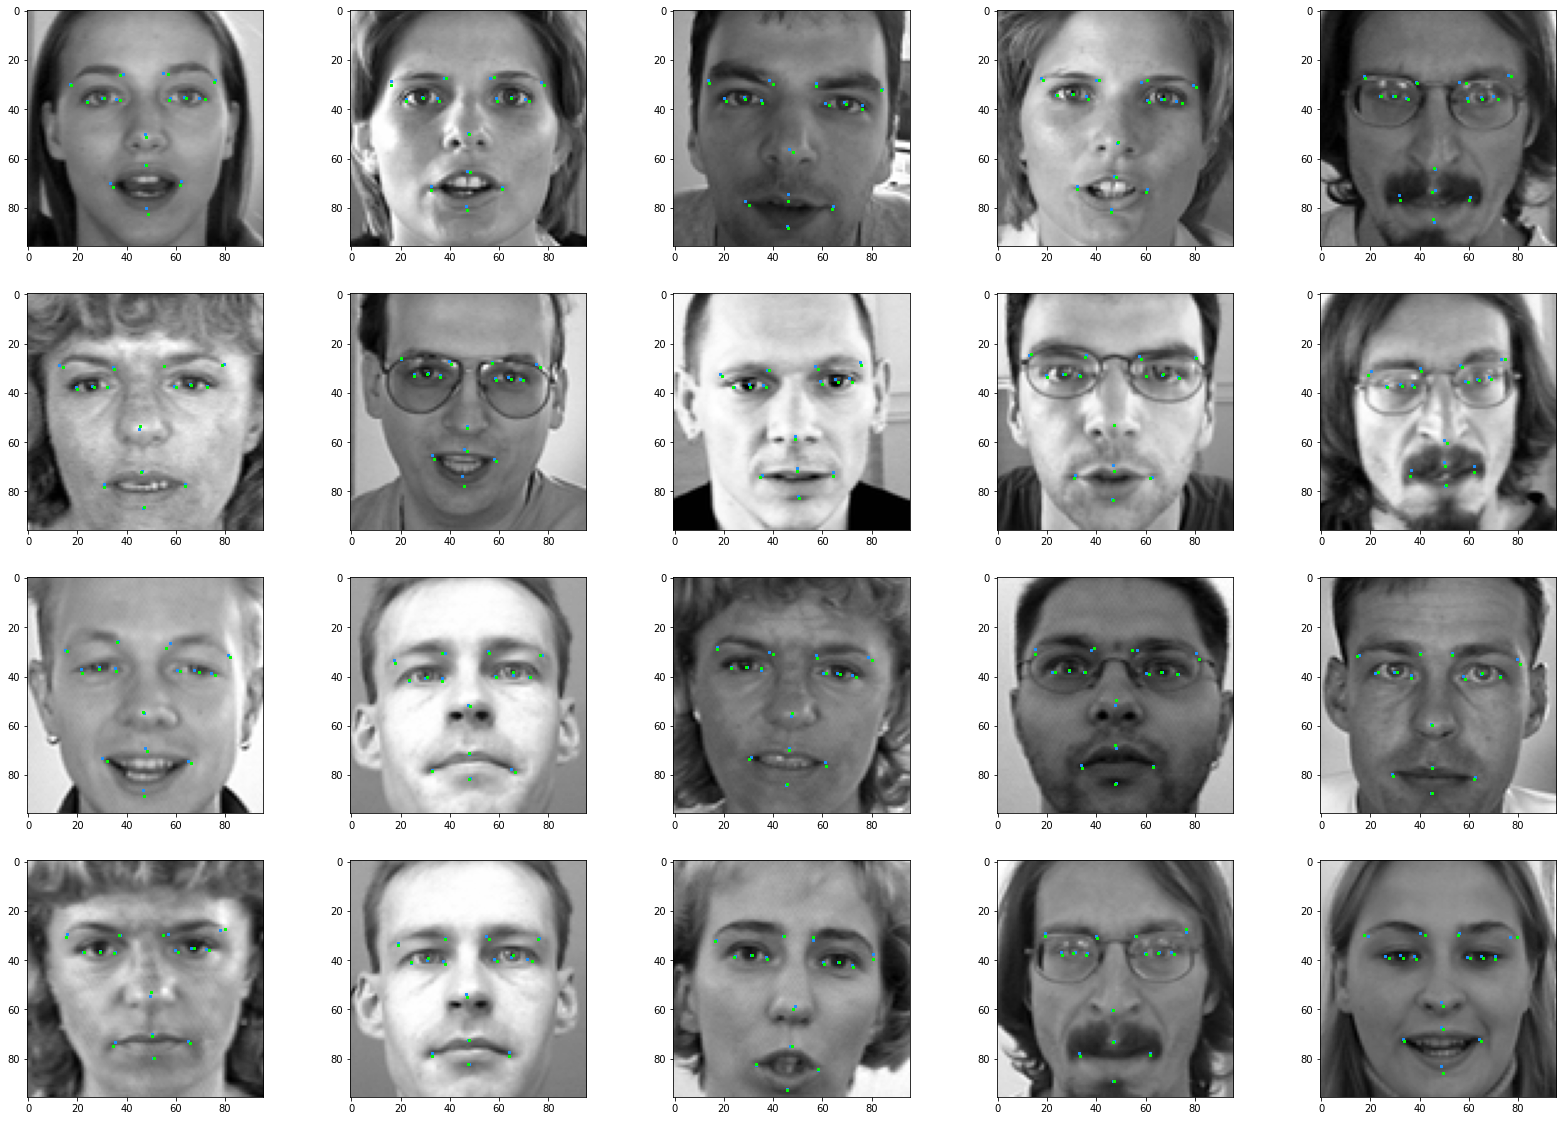

In [7]:
from testing import testOnDataset

print(">>> Model V4 <<<")
seed = 30 # Play around with the seed value to see the performance on different images.
testOnDataset(model, X_train[seed:seed+20], trueValues=y_train[seed:seed+20])

# If you want to compare it to V1 for example
# print("\n\n>>> Model V1 <<<")
# modelV1 = loadModel("../models/modelV1")
# testOnDataset(modelV1, X_train[seed:seed+20], trueValues=y_train[seed:seed+20])

## On a video file

Now to our actual intended use case. Sadly though Google Colab is to slow to test the model on live webcam input or video files directly but instead we can first predict on a given video, save that footage to another video and watch it afterwards.

To apply the model to real video footage we first need to find the face in the frame. Our model was only trained on the faces itself and not arbitrary surroundings. To detect the faces in the frames and get their location and size we use the Viola-Jones algorithm. Then we can process (mainly resizing and graying) that part of frame to fit the expected input of our model and after the prediction map the points to the frame itself.

In [8]:
from util.imageUtil import grayImage, mapPointsFromSquareToImage, resizeImageToModelSize, violaJones, violaJonesGetFaceCascade, drawPointsInImage, drawSquareInImage
from testing import predictOnImage
from tqdm import tqdm
import cv2 as cv

def testOnVideoFileColab(model, videoPath="../data/testVideos/406.avi", seconds=4):
  """Tests the model on a video file and stores the resulting video with the overlay."""
  print("\n> Testing the model on a video...")
  
  # Hyperparameters to set yourself
  showFrame = True    # If true draws a frame around the detected face
  minFaceSize = 0.4   # The minimum size to detect a face in the video in % of the frame size
  
  # Face detection
  c, r, s = 0, 0, 0  # Face location (column, row, sideLength)
  faceCascade = violaJonesGetFaceCascade()
  faceDetectionFrames = 10    # Every nth frame is used for face recognition
  faceDetectionCountdown = 5  # Number of faceDetectionFrames to wait before old data is discarded if no face is detected
  countdown = faceDetectionCountdown
  faceFound = False
  frameCount = 0

  cap = cv.VideoCapture(videoPath)
  width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
  fps = int(cap.get(cv.CAP_PROP_FPS))
  print(f"- Feed size: {width}x{height}")
  
  # Array to store the frames of the resulting video
  out = np.empty((0, height, width, 3), dtype=np.uint8)

  print(">> Predicting on the video...")
  for i in tqdm(range(fps * seconds)):
    if not cap.isOpened():
      break
    
    rv, frame = cap.read() # Read the next frame

    if not rv:
      break

    im = grayImage(frame)

    if frameCount % faceDetectionFrames == 0:
      # Search for faces using the viola-jones algorithm
      faces = violaJones(im, faceCascade, int(min(width, height)*minFaceSize))
      if len(faces) != 0:
        # Found a face and updates the location
        faceFound = True
        countdown = faceDetectionCountdown
        c, r, s1, s2 = faces[0]
        s = max(s1, s2)
      else:
        if (countdown == 0):
            faceFound = False
        else:
            countdown -= 1

    if faceFound:
      im = resizeImageToModelSize(im[r:r+s, c:c+s])
      x, y = predictOnImage(model, im)
      x, y = mapPointsFromSquareToImage(x, y, c, r, s)
      frame = drawPointsInImage(frame, x, y)
      if showFrame:
        frame = drawSquareInImage(frame, c, r, s)

    out = np.append(out, [frame], axis=0)

  cap.release()
  cv.destroyAllWindows()
  
  print(">> Writing the output video...")
  writer = cv.VideoWriter('output.mp4',cv.VideoWriter_fourcc(*'DIVX'), fps, (width, height))

  for i in tqdm(range(out.shape[0])):
    writer.write(out[i])
  writer.release()
  print("\n- Video made successfully!")
  
  return width, height

After defining the function to generate the output video by detecting the facial landmarks in the input video we can generate one from a test video from the [300-VW dataset](https://ibug.doc.ic.ac.uk/resources/300-VW/) which shows a person infront of a webcam.

In [9]:
width, height = testOnVideoFileColab(model, "../data/testVideos/406.avi", seconds=10)


> Testing the model on a video...
- Feed size: 1280x720
>> Predicting on the video...


100%|██████████| 290/290 [00:49<00:00,  5.90it/s]


>> Writing the output video...


100%|██████████| 290/290 [00:01<00:00, 192.86it/s]


- Video made successfully!


To view the video in Colab we first have to compress it.

In [10]:
from IPython.display import HTML
from base64 import b64encode
import os

save_path = "output.mp4" # Input video path
compressed_path = "output_compressed.mp4" # Compressed video path
# Compress video with ffmpeg to watch it in Colab
os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""<video width={width} height={height}  controls><source src="{data_url}" type="video/mp4"></video>""")